# SINDy in Neuromancer

This tutorial demonstrates the use of [sparse identification of nonlinear dynamics (SINDy)](https://arxiv.org/abs/1509.03580) in Neuromancer.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [2]:
import numpy as np
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode, library
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

Consider the [Thomas Attractor](https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor) defined by the [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation): 

$$
 \frac{dx_0}{dt} = sin(x_1) - b x_0
$$
$$
 \frac{dx_1}{dt} = sin(x_2) - b x_1
$$
$$
 \frac{dx_2}{dt} = sin(x_0) - b x_2
$$

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$.

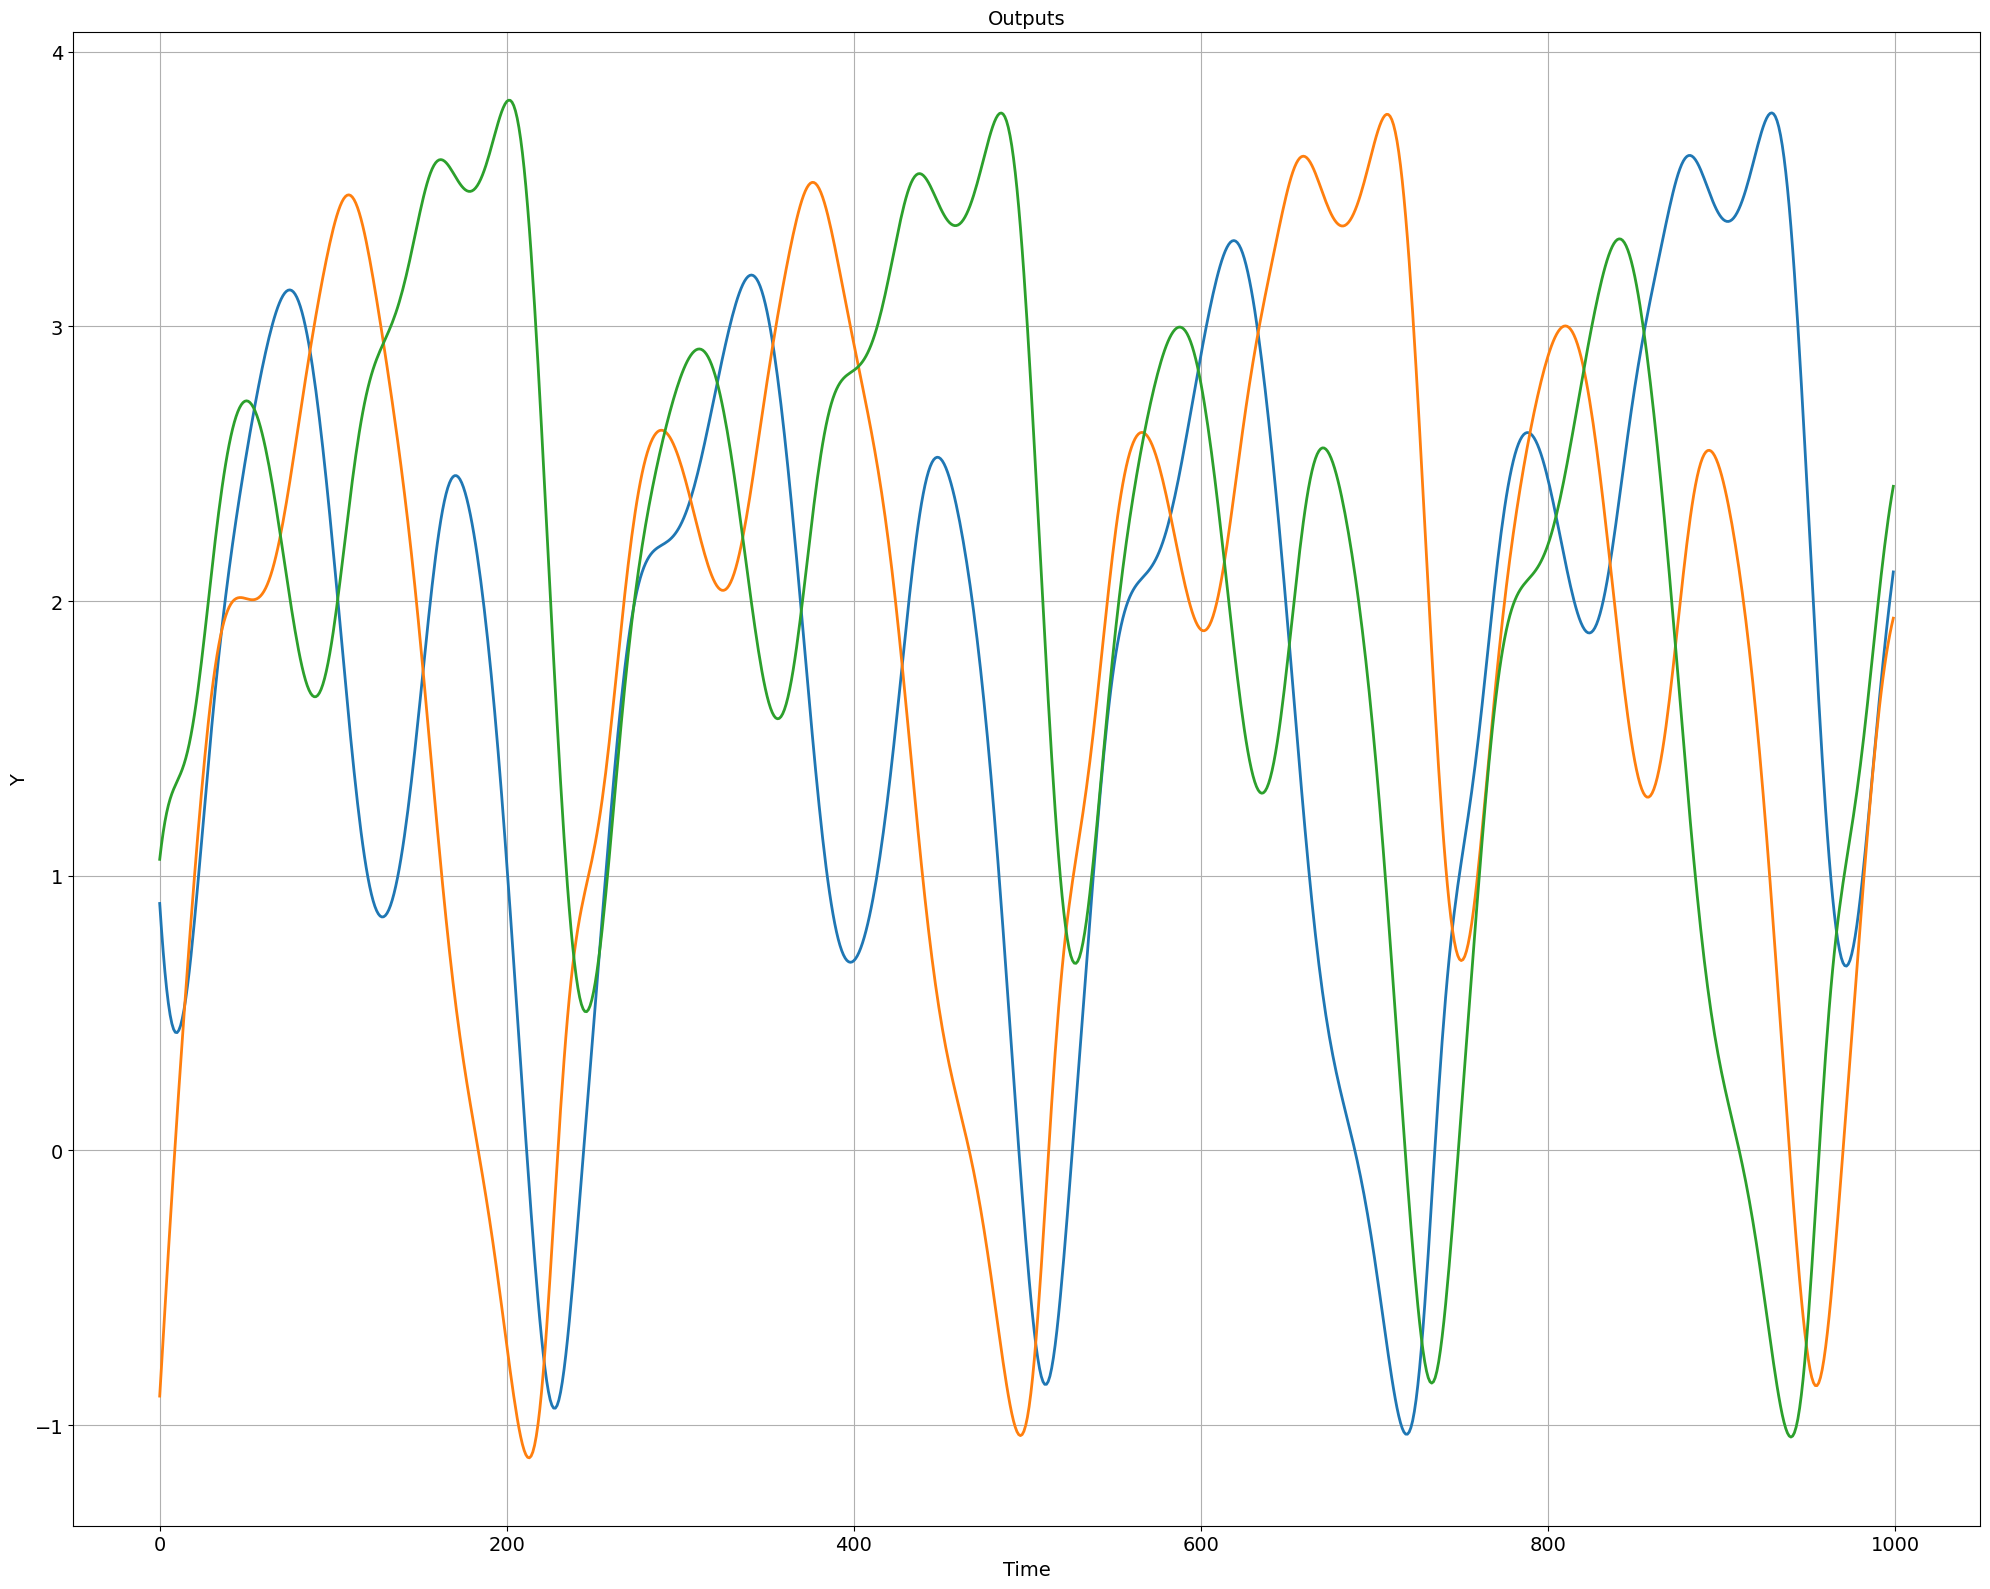

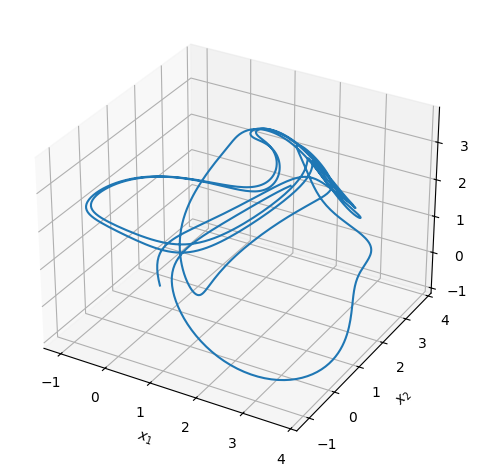

In [3]:
system = psl.systems['ThomasAttractor']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [4]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [5]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 10   # number of prediction horizon steps in the loss function
bs = 500     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

### Library Construction

Here, we create a library of candidate functions, using a combination of built-in functions and some custom functions.

This library will be used to evaluate $\theta(X)$, which is our set of functions evaluate for our state variables.

In [6]:
four_lib = library.FourierLibrary(nx, max_freq=1)

new_funs = np.append(four_lib.library, [lambda X: 1, lambda X: X[:,0], lambda X: X[:,1], lambda X: X[:,2]])

new_names = four_lib.function_names + ["1", "x0", "x1", "x2"]

lib = library.FunctionLibrary(new_funs, nx, new_names)
print(lib)

sin(1*x0), sin(1*x1), sin(1*x2), cos(1*x0), cos(1*x1), cos(1*x2), 1, x0, x1, x2


## SINDy system model

Here we construct a SINDy model $\dot{X} = \theta(X)\Xi$ with the trainable parameters $\Xi$.

In [7]:
torch.manual_seed(0)
fx = ode.SINDy(lib)

fxRK4 = integrators.RK4(fx, h=ts)
dynamics_model = System([Node(fxRK4, ['xn'], ['xn'])], nsteps=nsteps)

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [8]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\Xi}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(\theta(X)\Xi) \\
\end{align}
$$  

In [9]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

## Solve the problem

We fit the unknown SINDy parameters $\Xi$ using stochastic gradient descent.

In [10]:
optimizer = torch.optim.Adam(problem.parameters(),
                             lr=0.3)
# trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=200,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [11]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 8.948464393615723
epoch: 1  train_loss: 0.8264181017875671
epoch: 2  train_loss: 0.48909857869148254
epoch: 3  train_loss: 0.5405890941619873
epoch: 4  train_loss: 0.6511312127113342
epoch: 5  train_loss: 0.771418571472168
epoch: 6  train_loss: 0.8660717606544495
epoch: 7  train_loss: 0.9124426245689392
epoch: 8  train_loss: 0.91168612241745
epoch: 9  train_loss: 0.8825916051864624
epoch: 10  train_loss: 0.8456259965896606
epoch: 11  train_loss: 0.8138698935508728
epoch: 12  train_loss: 0.7914229035377502
epoch: 13  train_loss: 0.7758051156997681
epoch: 14  train_loss: 0.7628812193870544
epoch: 15  train_loss: 0.7492203712463379
epoch: 16  train_loss: 0.7328346371650696
epoch: 17  train_loss: 0.7133205533027649
epoch: 18  train_loss: 0.6914399862289429
epoch: 19  train_loss: 0.6686509847640991
epoch: 20  train_loss: 0.6469111442565918
epoch: 21  train_loss: 0.628516674041748
epoch: 22  train_loss: 0.615067720413208
epoch: 23  train_loss: 0.6072908639907837
epoch: 

<All keys matched successfully>

## Parameter estimation results

In [12]:
print(fx)

dx0/dt = 1.000*sin(1*x1) + -0.208*x0 
dx1/dt = 1.000*sin(1*x2) + -0.208*x1 
dx2/dt = 1.000*sin(1*x0) + -0.208*x2 



In [13]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [14]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

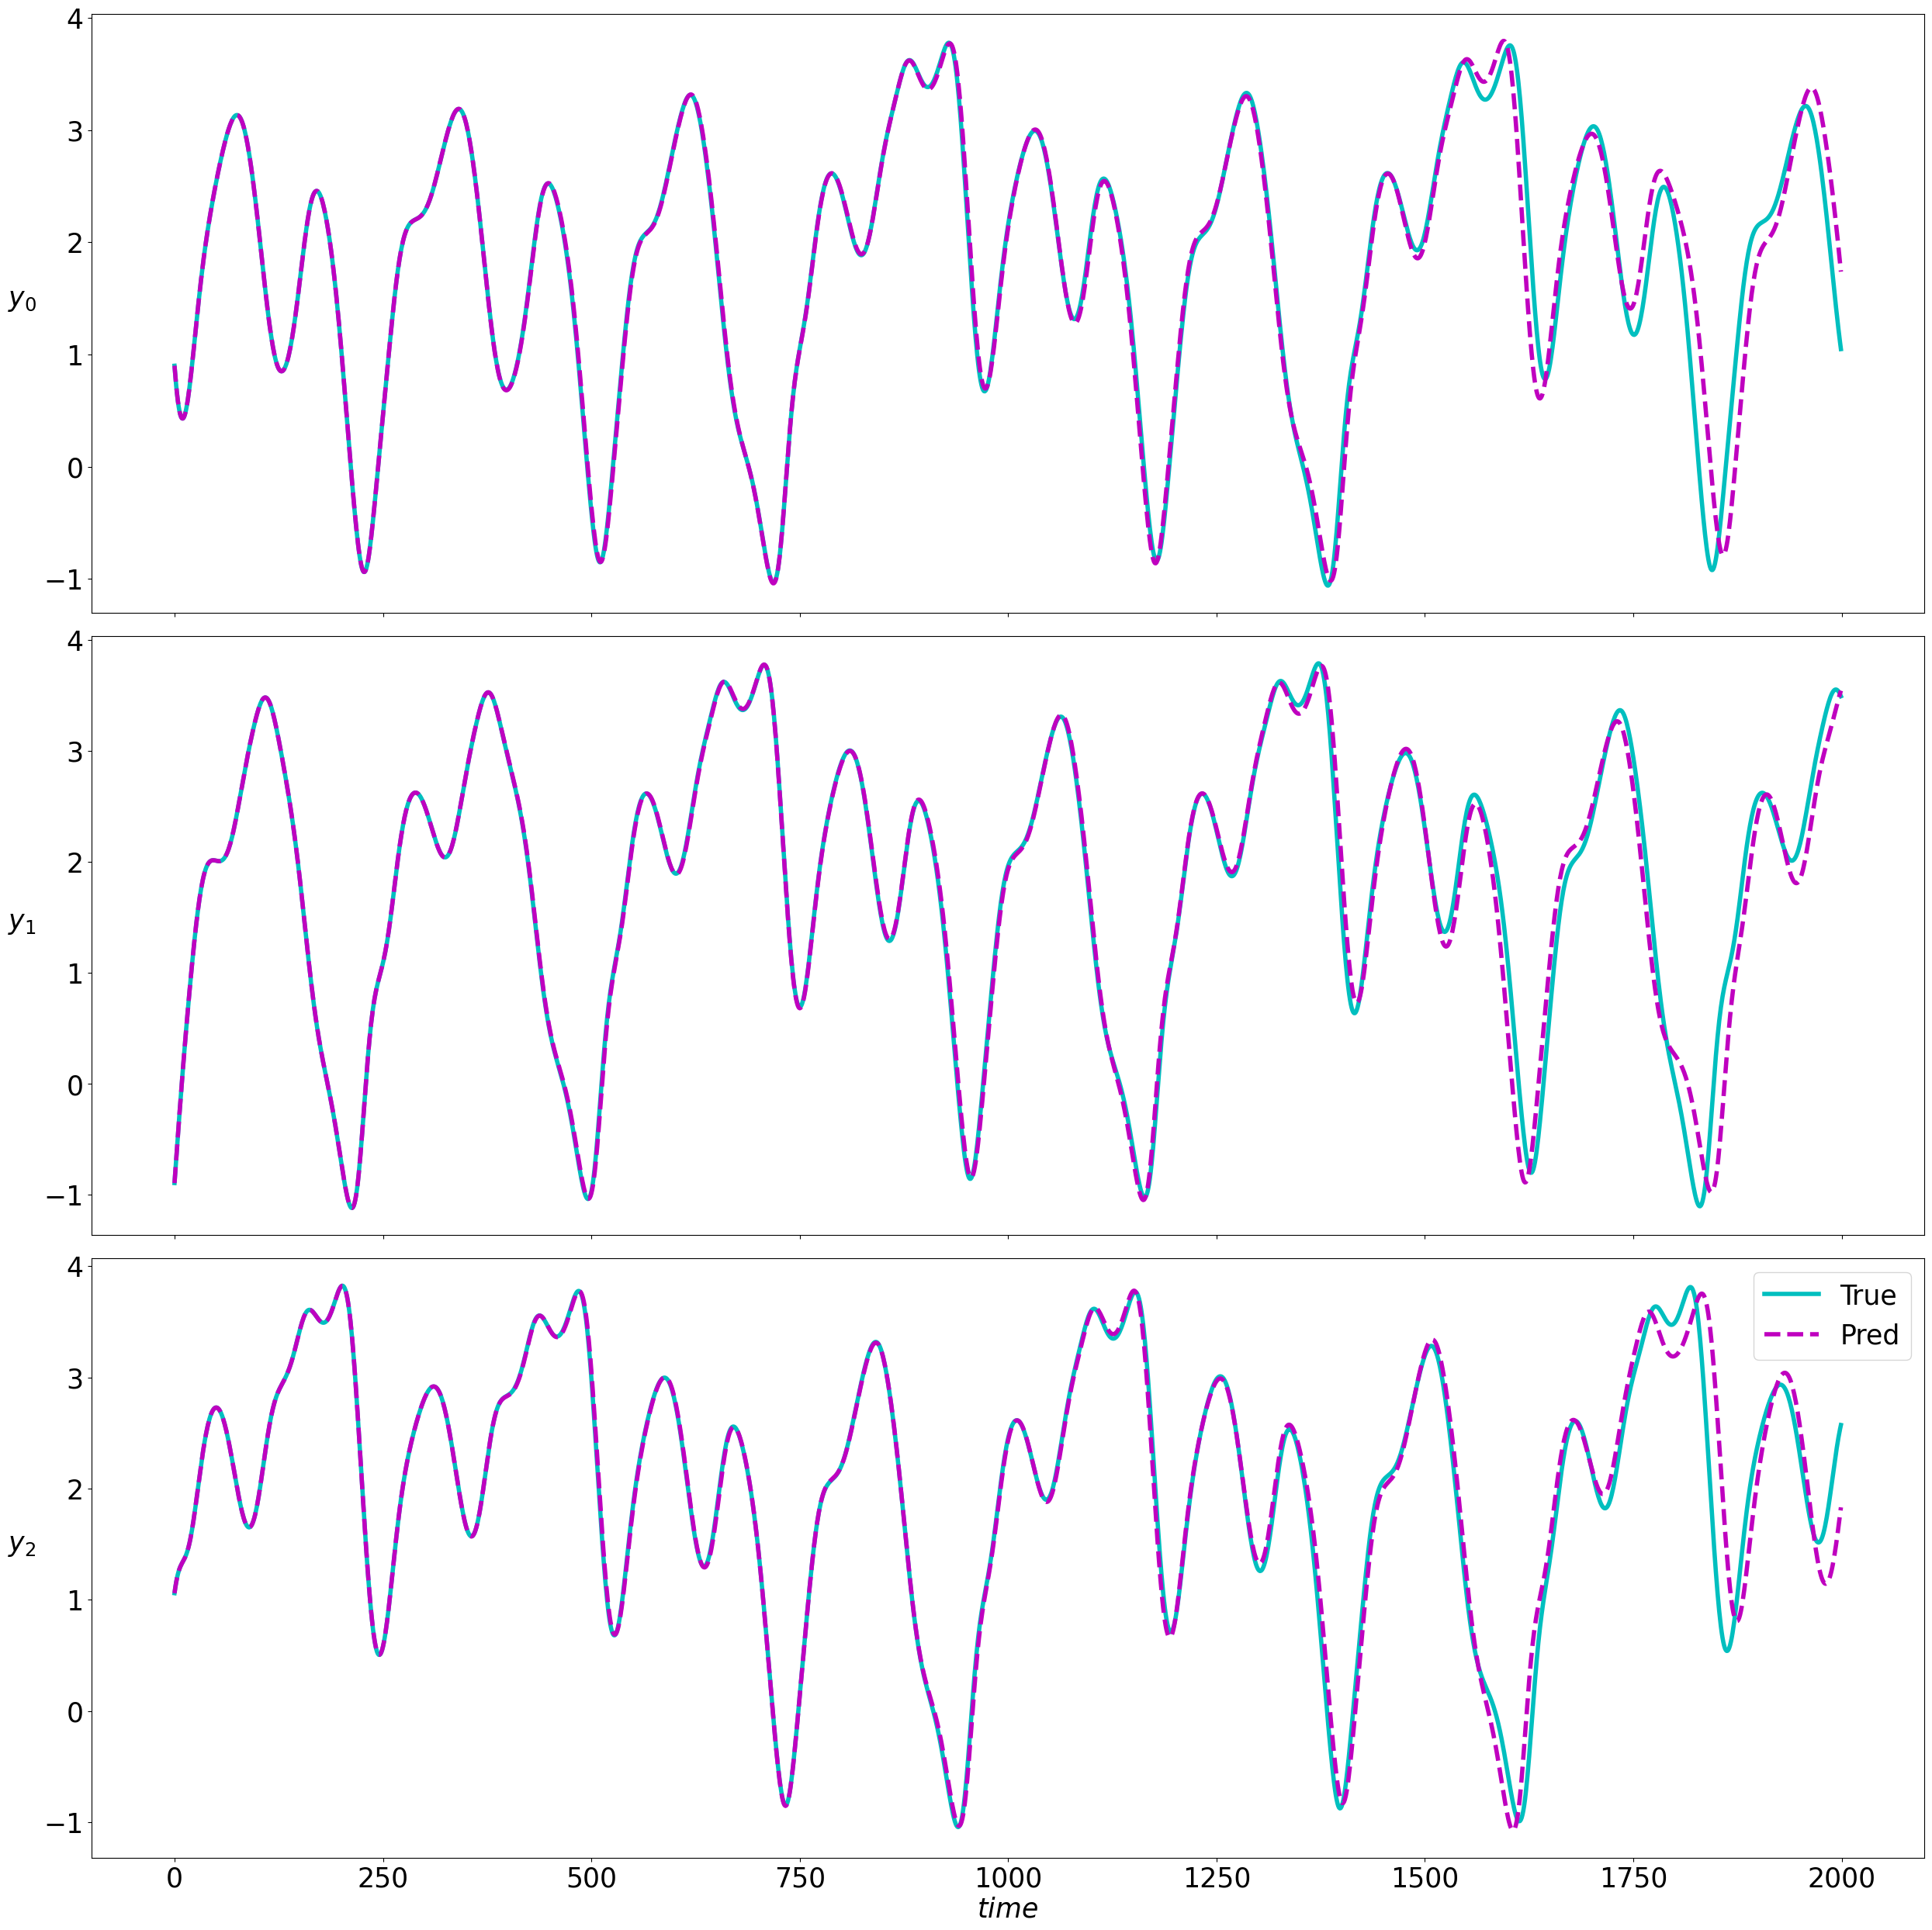

In [15]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()